## Попытка № 2. SVC / LinearSVC + TruncatedSVD.

In [2]:
from sklearn.svm import SVC  
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

np.random.seed(42)
random.seed(42)

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HYPERPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [20]:
df_train

,Unnamed: 0,text,label,text_lemmatized
0,12704,why don’t trade your btc to earn weekly rathe...,1,"['dont', 'trade', 'btc', 'earn', 'weekly', 'ra..."
1,1199027,"i’ll be honest, i didn’t see it sinking this ...",1,"['ill', 'honest', 'didnt', 'see', 'sinking', '..."
2,858781,-x needs to break 38 to hit 4 no shit lol,1,"['x', 'need', 'break', 'hit', 'shit', 'lol']"
3,972002,it's gonna be an all nighter ha?,1,"['gon', 'na', 'nighter', 'ha']"
4,1281138,y’all should just come to cro.x,2,"['yall', 'come', 'crox']"
...,...,...,...,...
928796,275576,"•which way, western man? btc vs. cbdc.",1,"['way', 'western', 'man', 'btc', 'v', 'cbdc']"
928797,121751,i love converting random micro denominations ...,1,"['love', 'converting', 'random', 'micro', 'den..."
928798,336428,finally figured out to be greedy when those ar...,2,"['finally', 'figured', 'greedy', 'fearful', 'f..."
928799,243449,didn’t you say your going to bed ??,2,"['didnt', 'say', 'going', 'bed']"


In [ ]:
X_train = df_train.text_lemmatized
X_test = df_test.text_lemmatized

y_train = df_train.label
y_test = df_test.label

In [32]:
# Возьмем подвыборку для подбора параметров моделей и возможных способов решения
X_train = df_train.text_lemmatized[:200000]
y_train = df_train.label[:200000]

X_test = df_test.text_lemmatized[:70000]
y_test = df_test.label[:70000]

In [34]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 4)) # используем уни, би, три, тетраграммы
vec_fit = vec.fit(X_train)

CPU times: total: 8.02 s
Wall time: 8.14 s


In [35]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

vec_train = vec_fit.transform(X_train)

In [36]:
# Попробуем обучить по частям для снижения переобучения
ran = np.arange(y_train.shape[0])
inds = np.array_split(ran, 10) # разбиваем на 10 частей и подмешиваем к каждому куску случайных объектов
inds = [np.concatenate((chunk, np.array(random.sample(list(ran), k=1000))), axis=None) for chunk in inds]

for chunk in tqdm(inds):
    svm.fit(vec_train[chunk, :], y_train.iloc[chunk])

100%|██████████| 10/10 [24:16<00:00, 145.64s/it]


In [37]:
pred = svm.predict(vec_fit.transform(X_test))
pred

array([1, 2, 2, ..., 1, 1, 2], dtype=int64)

In [38]:
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[  373  2685  3555]
 [  269 10545 17255]
 [  168  7110 28040]]
              precision    recall  f1-score   support

           0       0.46      0.06      0.10      6613
           1       0.52      0.38      0.44     28069
           2       0.57      0.79      0.67     35318

    accuracy                           0.56     70000
   macro avg       0.52      0.41      0.40     70000
weighted avg       0.54      0.56      0.52     70000

0.5565428571428571


In [39]:
f1_score(y_test, pred, average='micro')

0.5565428571428571

Возьмем подвыборку меньшего размера для определения лучших параметров с помощью GridSearchCV, тк на всех данных это длится очень долго.

In [4]:
X_train2 = df_train.text_lemmatized[:10000]
y_train2 = df_train.label[:10000]
X_test2 = df_test.text_lemmatized[:4300]
y_test2 = df_test.label[:4300]

Проверим процентное соотношение классов в обучающей подвыборке и сравним со всей выборкой.

In [44]:
y_train2.value_counts()

2    5011
1    4052
0     937
Name: label, dtype: int64

In [45]:
df_train.label.value_counts()

2    471774
1    370235
0     86792
Name: label, dtype: int64

| Класс      | Подвыборка | Выборка |
| ---------- |:----------:| -------:|
| 2          | `50 %` | `50 %` |
| 1          | `40 %` | `39,8 %` |
| 0          | `9,4 %` | `9,3 %` |

Подвыборка нам подходит.

In [8]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 4))
vec_fit2 = vec.fit(X_train2)

vec_train2 = vec_fit2.transform(X_train2)

CPU times: total: 469 ms
Wall time: 471 ms


In [9]:
vec_test2 = vec_fit2.transform(X_test2)

In [49]:
# Будем подбирать следующие параметры: 
# C - параметр регуляризации;
# gamma - 
# kernel - тип ядра

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}

svc_cv = GridSearchCV(SVC(), param_grid, cv=10, scoring='f1_micro')
svc_cv.fit(vec_train2, y_train2)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='f1_micro')

In [50]:
# Лучшая модель
print(svc_cv.best_estimator_)

SVC(C=1, gamma=1, kernel='sigmoid')


In [53]:
grid_predictions = svc_cv.predict(vec_test2)

print(confusion_matrix(y_test2, grid_predictions))
print(classification_report(y_test2, grid_predictions))

[[  4  72  79]
 [  4 307 531]
 [  1 215 787]]
              precision    recall  f1-score   support

           0       0.44      0.03      0.05       155
           1       0.52      0.36      0.43       842
           2       0.56      0.78      0.66      1003

    accuracy                           0.55      2000
   macro avg       0.51      0.39      0.38      2000
weighted avg       0.53      0.55      0.51      2000



In [54]:
f1_score(y_test2, grid_predictions, average='micro')

0.549

In [55]:
cf_matrix = confusion_matrix(y_test2,grid_predictions)

Построим confusion matrix в процентном соотношении классов.

<AxesSubplot: >

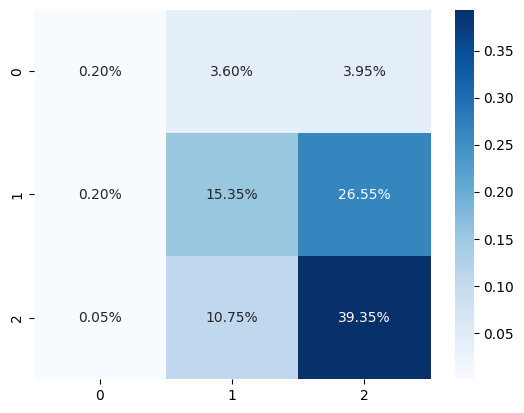

In [56]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

Проверим оценку на train.

In [57]:
pred_train = svc_cv.predict(vec_train2)

In [58]:
# Переобучение..
f1_score(y_train2, pred_train, average='micro')

0.8675

Посмотрим, что из себя представляет закодированная матрица обучающей выборки.

In [59]:
vec_train2

<10000x165250 sparse matrix of type '<class 'numpy.float64'>'
	with 240563 stored elements in Compressed Sparse Row format>

Признаков больше, чем объектов, переобучение очевидно. Попробуем снизить размерность. Будем использовать TruncatedSVD, тк PCA не работает с разреженными матрицами.

In [10]:
from sklearn.decomposition import TruncatedSVD

# Число компонент подбиралось экспериментально так, чтобы максимизировать суммарную дисперсию данных, при этом минимизировать количество признаков
clf = TruncatedSVD(4090)
Xpca = clf.fit_transform(vec_train2)

In [349]:
print(f'Доля дисперсии преобразованных данных от исходной выборки составила {sum(clf.explained_variance_ratio_)}.')

Доля дисперсии преобразованных данных от исходной выборки составила 0.5675206623910748.


In [239]:
Xpca.shape

(10000, 3090)

In [6]:
# Модель с оптимальными параметрами
svm2 = SVC(C=1.0, kernel='sigmoid', gamma=1, probability=True, random_state=822)

In [179]:
svm2.fit(Xpca, y_train2)

SVC(gamma=1, kernel='sigmoid')

In [11]:
ran = np.arange(y_train2.shape[0])
inds = np.array_split(ran, 10) 
inds = [np.concatenate((chunk, np.array(random.sample(list(ran), k=1000))), axis=None) for chunk in inds]

for chunk in tqdm(inds):
    svm2.fit(Xpca[chunk, :], y_train2.iloc[chunk])

100%|██████████| 10/10 [08:00<00:00, 48.07s/it]


In [13]:
# Снижаем размерность тестовых данных
Xpca_test = clf.transform(vec_test2)

In [14]:
pred_w_pca = svm2.predict(Xpca_test)

In [23]:
pred_svd_train = svm2.predict(Xpca)

### Метрики

$f1-score$

In [183]:
# train
f1_score(y_train2, svm2.predict(Xpca), average='micro') # svd(6090) не частями

0.7508000000000001

In [182]:
# test
f1_score(y_test2, pred_w_pca, average='micro')

0.552093023255814

$precision$

In [186]:
# test micro
precision_score(y_test2, pred_w_pca, average='micro')

0.552093023255814

In [26]:
# test macro
precision_score(y_test2, pred_w_pca, average='macro')

c:\Users\HYPERPC\Documents\HSE\Year1\ML\HW1\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3551073519843852

In [192]:
# train micro
precision_score(y_train2, pred_svd_train, average='micro')

0.7508

In [25]:
# train macro
precision_score(y_train2, pred_svd_train, average='macro')

0.6489656370688169

$recall$

In [190]:
# test micro
recall_score(y_test2, pred_w_pca, average='micro')

0.552093023255814

In [21]:
# test macro
recall_score(y_test2, pred_w_pca, average='macro')

0.35871300878205253

In [193]:
# train micro
recall_score(y_train2, pred_svd_train, average='micro')

0.7508

In [24]:
# train macro
recall_score(y_train2, pred_svd_train, average='macro')

0.3770802595053126

$ROC-AUC$

In [19]:
# test
roc_auc_score(y_test2, svm2.predict_proba(Xpca_test), multi_class='ovr')

0.5864924777693895

In [20]:
# train
roc_auc_score(y_train2, svm2.predict_proba(Xpca), multi_class='ovr')

0.6734674761381081

In [175]:
print(confusion_matrix(y_test2,pred_w_pca))
print(classification_report(y_test2,pred_w_pca))

[[   1   54  307]
 [   2  304 1457]
 [   0  220 1955]]
              precision    recall  f1-score   support

           0       0.33      0.00      0.01       362
           1       0.53      0.17      0.26      1763
           2       0.53      0.90      0.66      2175

    accuracy                           0.53      4300
   macro avg       0.46      0.36      0.31      4300
weighted avg       0.51      0.53      0.44      4300



Попробуем обучить LinearSVC, можно выиграть по времени и, возможно, по метрикам.

In [249]:
from sklearn.svm import LinearSVC
lsvm = LinearSVC( C=1, tol=1e-5, random_state=822)

In [242]:
# обучимся не по частям, проверим качество
lsvm.fit(Xpca, y_train2)

LinearSVC(C=1, random_state=0, tol=1e-05)

In [243]:
pred_lsvm = lsvm.predict(Xpca_test)

In [244]:
pred_lsvm_train = lsvm.predict(Xpca)

In [245]:
f1_score(y_train2, pred_lsvm_train, average='micro')

0.7431

In [246]:
f1_score(y_test2, pred_lsvm, average='micro')

0.546046511627907

Ситуация не улучшилась.